# Spectral profile of model predictions

This notebooks displays images computed from the script `spectral_profile.py`. We display WCAMs obtained across various training methods and model backbones to show that the sensitivity to distribution shifts can be explained by a shift in the important regions for the prediction, as highlighted by the WCAM. Existing attribution methods cannot provide such qualitative evidence while robustness analyses have only shown that robust methods are quantitatively less subject to distribution shifts, but did not explicited whether it was because the model behave qualitatively differently. 

In this work, we provide evidence that the attitude of deep learining models with respect to the scale decomposition of an image is the same across (1) model baselines and (2) training approaches. Differences in robustness between those methods are only quantitative. 

In [81]:
import sys
sys.path.append('../')

# Libraries 
import os
import json
import numpy as np 
import matplotlib.pyplot as plt
import torchvision
from PIL import Image
import cv2
import itertools
from utils import helpers, corruptions

In [8]:
# paths and parameters

data_path = '../../data/spectral-attribution-outputs/'
perturbation = "corruptions"

# cases to consider
cases = os.listdir(os.path.join(data_path, perturbation))
cases

In [21]:
# get the examples
baseline_path = os.path.join(os.path.join(data_path, perturbation), cases[0]) 
preds_baseline = json.load(open(os.path.join(baseline_path, "preds.json")))
altered_baseline = [i for i in os.listdir(baseline_path) if not i == "preds.json"]

pixmix_path = os.path.join(os.path.join(data_path, perturbation), cases[-1]) 
preds_pixmix = json.load(open(os.path.join(pixmix_path, "preds.json")))
altered_pixmix = [i for i in os.listdir(pixmix_path) if not i == "preds.json"]

adv_free = os.path.join(os.path.join(data_path, perturbation), cases[2]) 
preds_advf = json.load(open(os.path.join(adv_free, "preds.json")))
altered_advf = [i for i in os.listdir(baseline_path) if not i == "preds.json"]

# get the list of images that both models are sensitive to
examples = list(set(altered_baseline) & set(altered_pixmix) & set(altered_advf))

In [ ]:
adv_free = os.path.join(os.path.join(data_path, perturbation), cases[2]) 
preds_advf = json.load(open(os.path.join(adv_free, "preds.json")))
altered_advf = [i for i in os.listdir(baseline_path) if not i == "preds.json"]

# get the list of images that both models are sensitive to
examples = list(set(altered_baseline) & set(altered_pixmix) & set(altered_advf))

In [107]:
example = examples[4]
print(example)

preds_baseline[example], preds_advf[example], preds_pixmix[example]

altered_indices = []

for pred in [preds_baseline, preds_advf, preds_pixmix]:

    # retrive the indices of the failed predictions
    alterations = np.where(pred[example]['target'] == (pred[example]['source'] * np.ones(len(pred[example]['target']))))[0]
    print(alterations)
    # append them
    altered_indices.append(alterations.tolist())

# get the intersection
common_indices = list(set(altered_indices[0]) & set(altered_indices[1]) & set(altered_indices[2]))
common_indices

ILSVRC2012_val_00017138.JPEG
[1 2 4 5 6 9]
[ 2  4  6 11]
[ 0  1  3  4  5  6  7  8  9 10 11 12 13]


[4, 6]

In [94]:
# retrieve the corresponding wcams
# and images

index = 0
# image

preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224)
])
imagenet_dir = "../../data/ImageNet/"
source_image = preprocess(Image.open(os.path.join(imagenet_dir, example)).convert('RGB'))

# perturbated images 
corrupted_images = corruptions.corrupt_image(source_image)
corrupted_image = corrupted_images[-1]

# wcams
wcams = { 'source' : {
    'baseline' : Image.open(os.path.join(os.path.join(baseline_path, example), 'wcam_target_0.png')).convert('L'),
    'adv'      : Image.open(os.path.join(os.path.join(adv_free, example), 'wcam_target_0.png')).convert('L'),
    "robust"   : Image.open(os.path.join(os.path.join(pixmix_path, example), 'wcam_target_0.png')).convert('L')
    },
    'target' : {
    'baseline' : Image.open(os.path.join(os.path.join(baseline_path, example), 'wcam_source.png')).convert('L'),
    'adv'      : Image.open(os.path.join(os.path.join(adv_free, example), 'wcam_source.png')).convert('L'),
    "robust"   : Image.open(os.path.join(os.path.join(pixmix_path, example), 'wcam_source.png')).convert('L')
    }
    }



/data/GabrielKasmi/spectral-attribution/notebooks/../utils/make_imagenetc.py:301: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.21. Set `channel_axis=-1` explicitly to silence this warning.
  x = np.uint8(gaussian(np.array(x) / 255., sigma=c[0]) * 255)
/data/GabrielKasmi/spectral-attribution/notebooks/../utils/make_imagenetc.py:312: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.21. Set `channel_axis=-1` explicitly to silence this warning.
  return np.clip(gaussian(x / 255., sigma=c[0]), 0, 1) * 255
/data/GabrielKasmi/spectral-attribution/notebooks/../utils/make_imagenetc.py:293: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.21. Set `channel_axis=-1` explicitly to silence this warning.
  x = gaussian(np.array(x) / 255., sigm

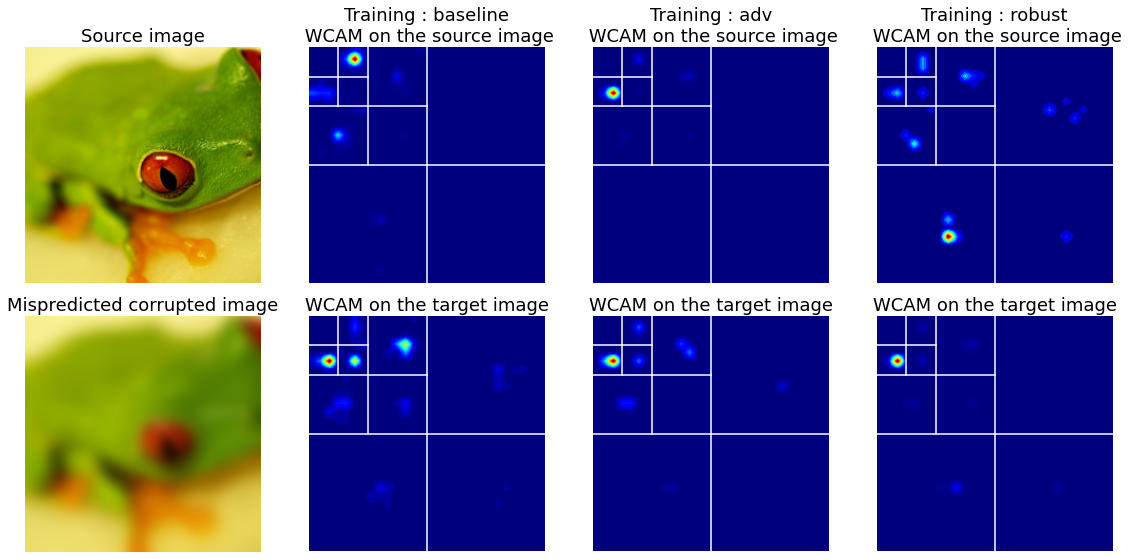

In [96]:
fig, ax = plt.subplots(2,4, figsize = (16, 8))
plt.rcParams.update({'font.size': 15})

levels = 3
size = 224

ax[0,0].set_title("Source image")
ax[0,0].imshow(source_image)

ax[1,0].set_title('Mispredicted corrupted image')
ax[1,0].imshow(corrupted_image)

for i, case in enumerate(['source', 'target']):
    for j, training in enumerate(['baseline', "adv", "robust"]):

        title = 'Training : {}'.format(training)

        wcam = np.array(wcams[case][training]).astype(np.uint8)
        wcam[:4, :4] = 0 # remove approximation coefficients
        resized_wcam = cv2.resize(wcam, (size,size)) # resize to match the dimensions of the image
        ax[i,j+1].imshow(resized_wcam, cmap = 'jet')
        helpers.add_lines(size, levels, ax[i,j+1])
        ax[0,j+1].set_title(title + '\n WCAM on the source image')
        ax[1,j+1].set_title('WCAM on the target image')

for i, j in itertools.product(range(2), range(4)):
    ax[i,j].axis('off')

fig.tight_layout()
plt.savefig('../figs/shift-prediction-methods.pdf')
plt.show()



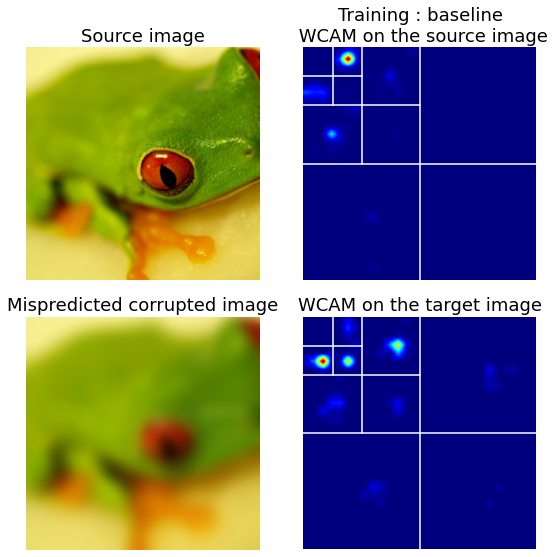

In [99]:
fig, ax = plt.subplots(2,2, figsize = (8, 8))
plt.rcParams.update({'font.size': 15})

levels = 3
size = 224

ax[0,0].set_title("Source image")
ax[0,0].imshow(source_image)

ax[1,0].set_title('Mispredicted corrupted image')
ax[1,0].imshow(corrupted_image)

for i, case in enumerate(['source', 'target']):
    for j, training in enumerate(['baseline']):#, "adv", "robust"]):

        title = 'Training : {}'.format(training)

        wcam = np.array(wcams[case][training]).astype(np.uint8)
        wcam[:4, :4] = 0 # remove approximation coefficients
        resized_wcam = cv2.resize(wcam, (size,size)) # resize to match the dimensions of the image
        ax[i,j+1].imshow(resized_wcam, cmap = 'jet')
        helpers.add_lines(size, levels, ax[i,j+1])
        ax[0,j+1].set_title(title + '\n WCAM on the source image')
        ax[1,j+1].set_title('WCAM on the target image')

for i, j in itertools.product(range(2), range(2)):
    ax[i,j].axis('off')

fig.tight_layout()
plt.savefig('../figs/shift-prediction-methods-baseline.pdf')
plt.show()



In [108]:
editing_dir = "../../data/ImageNet-E/"
os.listdir(editing_dir)

['20_smooth',
 'rp',
 'ori',
 'vis.py',
 '008',
 '20_adv',
 'eval.py',
 '005',
 '01',
 'full',
 'random_bg',
 'labels.txt',
 '20_hard',
 'rd',
 'rec']

In [109]:
name = "ILSVRC2012_val_00017138.JPEG"
name in os.listdir(os.path.join(editing_dir, "full"))

False

In [118]:
# imagenet E baseline
import torch 
import torchvision
from torchvision.models import resnet50

normalize = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
])

batch_size = 128
device = 'cuda'
model = resnet50(pretrained=True).to(device)

names = ['ILSVRC2012_val_00006431.JPEG',
 'ILSVRC2012_val_00048422.JPEG',
 'ILSVRC2012_val_00046053.JPEG',
 'ILSVRC2012_val_00009602.JPEG',
 'ILSVRC2012_val_00021215.JPEG',
 'ILSVRC2012_val_00032235.JPEG',
 'ILSVRC2012_val_00029013.JPEG',
 'ILSVRC2012_val_00031784.JPEG']

images = [helpers.retrieve_edited_samples(editing_dir, name, preprocessing = None) for name in names]


samples = {}

for image, name in zip(images, names):

    samples[name] = torch.stack([
        normalize(im) for im in image
    ])


preds = {name : helpers.evaluate_model_on_samples(samples[name], model, batch_size) for name in samples.keys()}

In [120]:
preds['ILSVRC2012_val_00048422.JPEG']

array([328., 328., 328.,  97., 328., 328., 328., 947., 328., 109., 328.,
       328.])